In [2]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
# Import module for k-means
from sklearn.cluster import KMeans, DBSCAN
#import module k-prototype
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.max_columns', None)


# prepocessing sklearn
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

#Pour la localisation du coude
from kneed import KneeLocator, DataGenerator as dg

In [3]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','order_purchase_timestamp','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120


In [4]:
from collections import Counter

outre_cat=list((Counter(df.product_category.value_counts().index.to_list())-Counter(df.product_category.value_counts().index.to_list()[0:10])).elements())
outre_cat
df.replace(outre_cat,"other", inplace=True)
df.product_category.value_counts()

Home                   22393
Technology             13021
Health_Beauty          11351
Fashion_Accessories     8533
Toys_Games              7941
Sports_Leisure          7101
other                   6291
Construction_Tools      5003
Automotive              3722
Office_Supplies         3370
Baby                    2753
Name: product_category, dtype: int64

In [50]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (MinMaxScaler(),make_column_selector(dtype_include=np.number))
    )

In [51]:
df = transformer.fit_transform(df)
df=pd.DataFrame(df)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.001210,1.00,0.019164,0.029291,0.159712
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000161,0.75,0.002680,0.020235,0.164029
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000701,0.50,0.010120,0.042033,0.772662
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.000311,0.75,0.003733,0.043034,0.461871
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.250000,0.000000,0.000000,0.000000,0.001714,1.00,0.026603,0.041227,0.414388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416667,0.013514,0.013514,0.013514,0.037741,1.00,0.116444,0.607084,0.643165
91475,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000686,0.75,0.009510,0.048062,0.376978
91476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000941,1.00,0.013224,0.055067,0.817266
91477,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208333,0.000000,0.000000,0.000000,0.001135,1.00,0.016951,0.045621,0.171223


In [45]:
# Choose optimal K using Elbow method
inertia = []
for cluster in range(1, 10):
        kmeans = KMeans( n_clusters = cluster)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        print('Cluster initiation: {}'.format(cluster))



Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


Text(0, 0.5, 'Cout du modèle (inertia)')

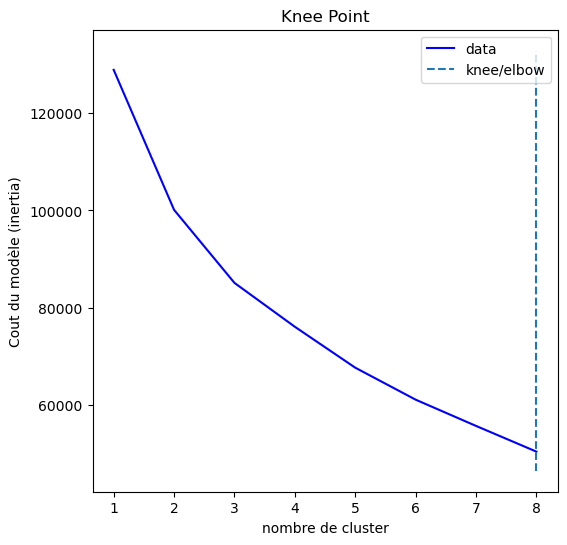

In [46]:
x,y = range(1,9),inertia[:-1]
kl = KneeLocator(x,y, curve='convex')
kl.plot_knee()
plt.xlabel('nombre de cluster')
plt.ylabel('Cout du modèle (inertia)')

In [326]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','order_purchase_timestamp','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120


In [114]:
a = FunctionTransformer(func=np.log1p)
preprocessing = make_column_transformer((a,make_column_selector(dtype_include=np.number)),remainder='passthrough')
log=preprocessing.fit_transform(df)
log[0]

array([2.1972245773362196, 0.6931471805599453, 0.6931471805599453,
       0.6931471805599453, 4.9621450849358215, 1.791759469228055,
       4.874433672915854, 2.5649493574615367, 4.727387818712341,
       'credit_card', 'Home'], dtype=object)

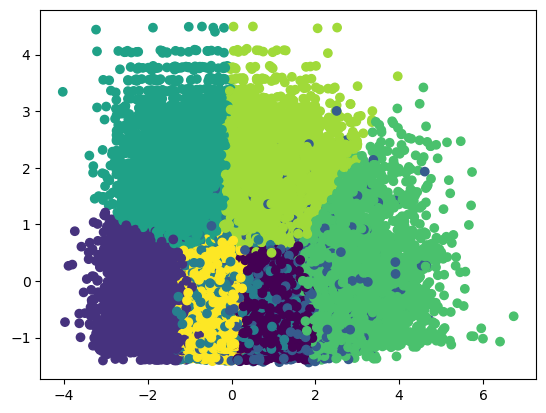

In [53]:
func_log = FunctionTransformer(func=np.log1p)
func_abs=FunctionTransformer(func=np.abs)

pipe_num= make_pipeline(func_abs,func_log)

transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=['float','int'])),
    (pipe_num,make_column_selector(dtype_include=['float','int']))
    )

pipe_pca= make_pipeline(transformer,PCA(n_components=0.95))

df_acp=pd.DataFrame(pipe_pca.fit_transform(df))


clustering =KMeans(n_clusters=8).fit(df_acp)
df_acp['cluster_labels']=pd.Series(clustering.labels_)


plt.scatter(df_acp.iloc[:,0],df_acp.iloc[:,1],c=df_acp.cluster_labels)
plt.show()

In [54]:
df_num=df[['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency']]

mms=MinMaxScaler(feature_range=(1,5))

num_cols= df.select_dtypes(include='number').columns
df_num['cluster_labels']=pd.Series(clustering.labels_)

list_agg = {}
for col in num_cols:
    list_agg[f'{col}'] = 'mean'

df_mean=df_num.groupby('cluster_labels').agg(list_agg)


df_mms=pd.DataFrame(mms.fit_transform(df_mean),columns=['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency'])
df_mms


/tmp/ipykernel_54326/439567709.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,3.859305,1.000000,1.000000,1.000000,1.714134,3.971874,1.932148,2.201587,5.000000
1,1.359757,1.103904,1.103904,1.103904,1.000000,4.209667,1.000000,1.000000,4.824078
2,3.100390,5.000000,5.000000,5.000000,4.424604,1.000000,1.406312,1.622579,4.558901
3,1.000000,1.165360,1.165360,1.165360,1.462991,3.994643,1.516549,1.767930,4.840711
4,1.510065,1.131128,1.131128,1.131128,1.123011,5.000000,1.130567,1.210166,1.000000
5,5.000000,1.294998,1.294998,1.294998,5.000000,3.497751,5.000000,5.000000,4.304414
6,3.045066,1.229180,1.229180,1.229180,1.858568,4.926599,1.874977,2.700884,1.068697
7,2.193814,1.113719,1.113719,1.113719,1.226690,4.134865,1.277023,1.295037,4.812360


In [55]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_mms.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=num_cols,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)

In [56]:
# func_log = FunctionTransformer(func=np.log1p)
# func_abs=FunctionTransformer(func=np.abs)

# pipe_num= make_pipeline(func_abs,func_log)

# transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=['float','int'])),
#     (pipe_num,make_column_selector(dtype_include=np.number)),remainder='passthrough')


# pipe_tsne = make_pipeline(transformer,TSNE()) 
# array_tsne=pipe_tsne.fit_transform(df)

# kprototype = KPrototypes(n_jobs = -1, n_clusters =4, init = 'Huang', random_state = 0)
# kprototype.fit_predict(array_tsne, categorical = [9,10])

# df_tsne=pd.DataFrame(array_tsne,columns=['f1','f2'])
# df_tsne['cluster_labels']=pd.Series(kprototype.labels_)

# plt.scatter(df_tsne.f1,df_tsne.f2,c=df_tsne.cluster_labels)
# plt.show()

In [57]:
dummy_product=pd.get_dummies(df.product_category,sparse=False)
prod_col=dummy_product.columns.to_list()

list_agg = {}
for col in prod_col:
    list_agg[f'{col}'] = 'sum'

dummy_product['cluster_labels']=pd.Series(clustering.labels_)

df_cat=dummy_product.groupby('cluster_labels').agg(list_agg)

cluster_count=dummy_product.cluster_labels.value_counts().sort_index().to_list()
for i in range(len(cluster_count)):
    df_cat.iloc[i]=(df_cat.iloc[i])/(cluster_count[i])


df_mms_cat=pd.DataFrame(mms.fit_transform(df_cat), columns=prod_col)
df_mms_cat


,Automotive,Baby,Construction_Tools,Fashion_Accessories,Health_Beauty,Home,Office_Supplies,Sports_Leisure,Technology,Toys_Games,other
0,3.125039,3.791292,2.249359,4.274029,3.120416,1.915102,5.000000,4.502751,1.027510,5.000000,1.000000
1,2.825060,1.263388,1.000000,1.032706,2.038173,1.024992,1.000000,1.983940,5.000000,2.300637,2.355224
2,1.000000,1.000000,5.000000,1.000000,1.000000,5.000000,3.346049,3.161105,1.314551,1.000000,1.678122
3,2.508526,3.177910,3.689592,2.671148,2.610198,2.340738,4.024915,5.000000,1.372795,3.530384,2.361245
4,5.000000,5.000000,2.540212,1.921403,3.997402,2.323421,1.850246,3.268105,1.756944,1.579356,5.000000
5,4.618693,4.946528,4.145205,5.000000,4.903448,1.000000,2.396862,1.000000,1.171432,4.051025,3.597457
6,3.195254,4.117505,3.864369,3.916737,5.000000,2.531389,3.248752,1.574032,1.000000,1.862494,3.279240
7,1.776685,3.841051,3.123793,2.491621,3.452831,3.099613,2.849090,4.442643,1.003487,3.505834,2.026940


In [58]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_mms_cat.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=prod_col,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)